In [7]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet 
import statsmodels.tsa.stattools as ts
 
from helper import clean_data
from helper import vix_prime_combine
from helper import dftest
from helper import split_data

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
vix_close , prime, weekly_vix, monthly_vix = clean_data()

## Data Distribution

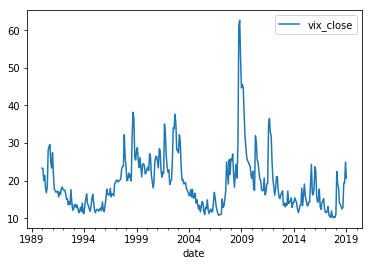

In [21]:
monthly_vix.plot() ## do I need to worry about the financial meltdown? Probably.

In [9]:
monthly_vix.columns

Index(['vix_close'], dtype='object')

In [53]:
annual_vix = vix_close.resample('A').mean()

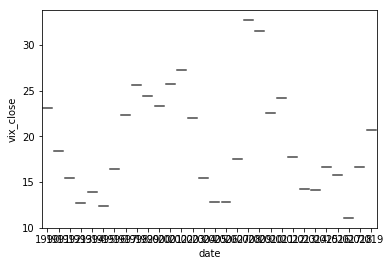

In [54]:
sns.violinplot(x=annual_vix.index.year,y=annual_vix.vix_close)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


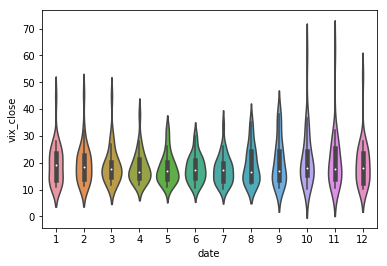

In [19]:
sns.violinplot(x=monthly_vix.index.month,y=monthly_vix.vix_close)

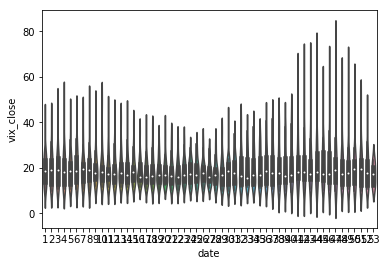

In [23]:
sns.violinplot(x=weekly_vix.index.week,y=weekly_vix.vix_close) ## volitility spikes in fall and winter

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


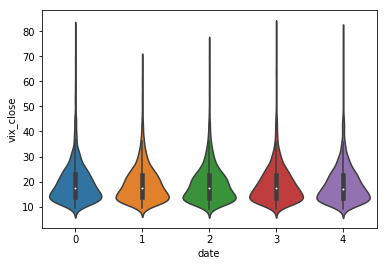

In [22]:
sns.violinplot(x=vix_close.index.dayofweek,y=vix_close.vix_close) #Monday - Friday doesn't matter.

## tests from class

In [47]:
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()


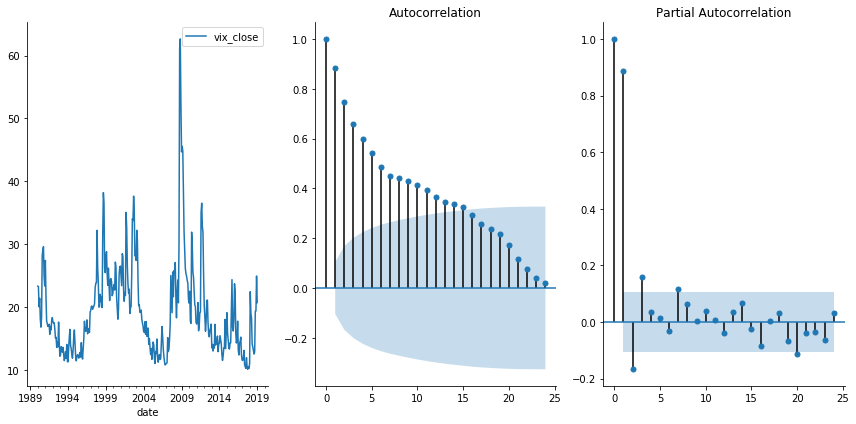

In [48]:
plots(monthly_vix, lags=24);


In [49]:
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_vix.vix_close, order=(1,1,0), seasonal_order=(0,1,0,12), trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          vix_close   No. Observations:                  349
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1022.475
Date:                            Mon, 21 Jan 2019   AIC                           2050.949
Time:                                    13:53:05   BIC                           2062.401
Sample:                                01-31-1990   HQIC                          2055.514
                                     - 01-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0113      0.278      0.041      0.967      -0.534       0.557
ar.L1          0.1081      0.048      2.266      0.023       0.015       0.202
sigma2        25.7451      1.092     23.584      0.000      23.606      27.885
===================================================================================
Ljung-Box (Q):                      185.52   Jarque-Bera (JB):              1275.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

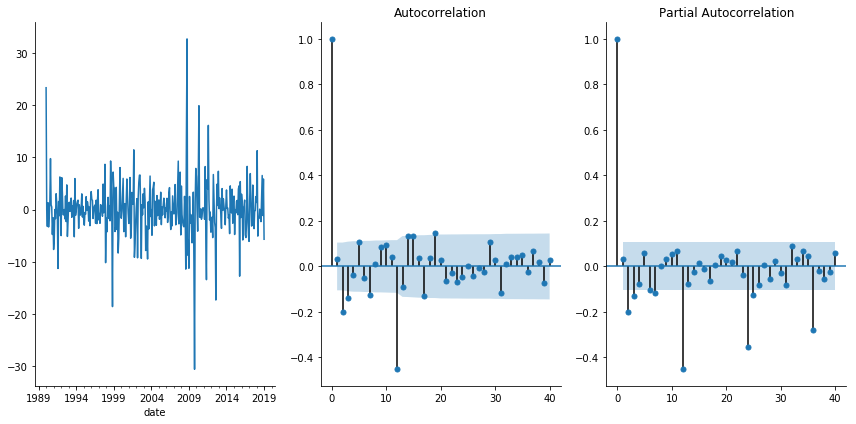

In [50]:
plots(sar.resid, lags=40);

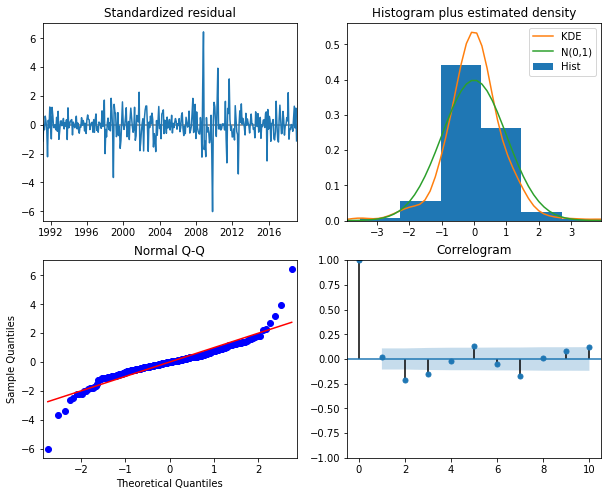

In [51]:
sar.plot_diagnostics(figsize=(10, 8));

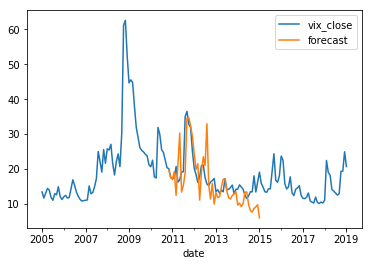

In [52]:
monthly_vix['forecast'] = sar.predict(start = 250, end= 300, dynamic=30)  
monthly_vix[180:][['vix_close', 'forecast']].plot();

## Try data as % change

In [42]:
# Let's try in percent change
vix_df = vix_close.vix_close.diff()/vix_close.vix_close

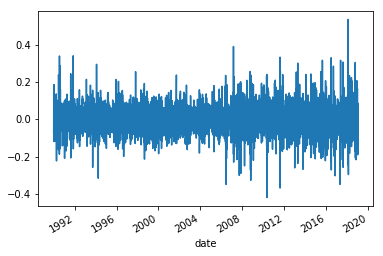

In [43]:
vix_df.plot()

In [46]:
vix_df

date
2004-01-02         NaN
2004-01-05   -0.041738
2004-01-06   -0.045427
2004-01-07   -0.079355
2004-01-08    0.007047
2004-01-09    0.068060
2004-01-12    0.004162
2004-01-13    0.067627
2004-01-14   -0.077015
2004-01-15   -0.076478
2004-01-16   -0.037333
2004-01-20    0.013807
2004-01-21   -0.060669
2004-01-22    0.025153
2004-01-23    0.008760
2004-01-26   -0.019931
2004-01-27    0.052117
2004-01-28    0.085221
2004-01-29    0.021004
2004-01-30   -0.030667
2004-02-02    0.028054
2004-02-03    0.013264
2004-02-04    0.029659
2004-02-05   -0.009034
2004-02-06   -0.106875
2004-02-09    0.023795
2004-02-10   -0.028231
2004-02-11   -0.035737
2004-02-12   -0.005225
2004-02-13    0.017330
                ...   
2003-11-20    0.034908
2003-11-21   -0.026344
2003-11-24   -0.088303
2003-11-25   -0.043686
2003-11-26   -0.029575
2003-11-27    0.158041
2003-11-28   -0.181157
2003-12-01    0.026834
2003-12-02   -0.030731
2003-12-03    0.021648
2003-12-04   -0.020245
2003-12-05    0.046226
2003-1

In [30]:
monthly_vix.head()

,vix_close
date,
1990-01-31,23.347273
1990-02-28,23.262632
1990-03-31,20.062273
1990-04-30,21.403500
1990-05-31,18.097727
